## Interface utilisateur pour Sakila
1. Créer un fonction connect_db() qui prendra en entrée un dictionnaire contenant un nom d’utilisateur, un mot de passe, un host et le nom d’une base de données.
2. Créer une fonction new_customer() qui va permettre l’insertion d’un nouveau client dans la table customer en demandant à un utilisateur de saisir les données, ainsi que son adresse pour remplir les tables address, city et country. Faire attention au contrainte d’intégrité.

In [27]:
import json

with open("sql_credentials.json") as file:
    data = json.load(file)
    myUser = data["user"]
    myPassword = data["password"]
    myHost = data["host"]

In [70]:
from sqlalchemy import create_engine
import pandas as pd 

def connect_db(user, password, host, bd):
    s = "mysql+pymysql://"
    s += user+":"+password+"@"+host+"/"+bd
    return create_engine(s)

def new_customer(engine):

    print("Veuillez remplir les informations du client à ajouter :\n")

    print("Nom :", nom)
    prenom = (input("Prénom :")).upper()
    print("__ Informations client __")
    nom = (input("Nom :")).upper()
    print("Prénom :", prenom)
    email = input("Email :")
    print("Email :", email)
    phone = input("Téléphone :")
    print("Téléphone :", phone)
    print("________ Adresse ________")
    address = input("Adresse (ligne1) :")
    print(address)
    address2 = input("Adresse (ligne2) :")
    print(address2)
    city = input("Ville :")
    print(city)
    postal_code = input("Code postal :")
    print(postal_code)
    country = input("Pays : ")
    print(country)

    listCountries = pd.read_sql_query("SELECT * FROM country;", engine)

    if country not in list(listCountries["country"]):

        s = "INSERT INTO country (country) \
             VALUES ('%s');" %(country)

        engine.execute(s)

    listCities = pd.read_sql_query("SELECT * FROM city;", engine)

    if city not in list(listCities["city"]):
        
        s = "INSERT INTO city (city, country_id) \
             VALUES ('%s', \
                     (SELECT country_id FROM country WHERE country = '%s' LIMIT 1) ) ;" %(city,country)
    
        engine.execute(s)

    listAddresses = pd.read_sql_query("SELECT * FROM address;", engine)
    listAddresses = listAddresses.fillna(" ")
    listAddresses["concatenee"] = listAddresses["address"]+" "+listAddresses["address2"]+" "+listAddresses["postal_code"]

    if (address+" "+address2+" "+postal_code) not in list(listAddresses["concatenee"]):
        s = "INSERT INTO address (address, address2, district, city_id, postal_code, phone, location) \
             VALUES ('%s', \
                     '%s', \
                     ' ', \
                     (SELECT city_id FROM city WHERE city = '%s' LIMIT 1), \
                     '%s', \
                     '%s', \
                     ST_GeomFromWKB(X'0101000000000000000000F03F000000000000F03F' ) ) ;" %(address, address2, city, postal_code, phone)
        
        engine.execute(s)


    s = "INSERT INTO customer (store_id, first_name, last_name, email, address_id, active, create_date) \
         VALUES (1, \
                 '%s', \
                 '%s', \
                 '%s', \
                 (SELECT address_id FROM address WHERE address = '%s' AND address2 = '%s' AND postal_code = '%s'), \
                 1, \
                 CURRENT_DATE() ) ;" %(prenom, nom, email, address, address2, postal_code)

    engine.execute(s)

    print("\n")
    print("Client ajouté avec succès")
    print(pd.read_sql_query("SELECT * FROM customer WHERE concat(first_name,' ',last_name) = '%s %s'" %(prenom, nom), engine))

    return 

In [71]:
sakila = connect_db(myUser, myPassword, myHost, "sakila")

queryNewCustomer = new_customer(sakila)

Veuillez remplir les informations du client à ajouter :
__ Informations client __
Nom : MBAPPE
Prénom : KYLIAN
Email : kmb@gmail.com
Téléphone : 0888888888
________ Adresse ________
12 Champs Elysées
Résidence France
Paris
75000
France
Client ajouté avec succès
   customer_id  store_id first_name last_name          email  address_id  \
0          604         1     KYLIAN    MBAPPE  kmb@gmail.com         610   

   active         create_date         last_update  
0       1 2021-05-26 13:54:22 2021-05-26 13:54:22  


3. Ecrire une fonction qui va afficher l’historique de location d’un client.



In [15]:
import pandas as pd

def historique(nom,prenom,engine):

    s =  "SELECT r.rental_date, f.title "
    s += "FROM customer as c "
    s += "JOIN rental as r ON c.customer_id = r.customer_id "
    s += "JOIN inventory as i ON r.inventory_id = i.inventory_id "
    s += "JOIN film as f ON i.film_id = f.film_id "
    s += "WHERE (concat(c.first_name,' ', c.last_name) = '%s %s')" %(prenom.upper(),nom.upper())

    histo = pd.read_sql_query(s, engine)

    return histo

In [28]:
sakila = connect_db(myUser, myPassword, myHost, "sakila")

hist = historique("smith","mary",sakila)

hist

,rental_date,title
0,2005-08-01 08:51:04,ADAPTATION HOLES
1,2005-07-29 03:58:49,AMISTAD MIDSUMMER
2,2005-06-18 08:41:48,ATTACKS HATE
3,2005-08-22 20:03:46,BIKINI BORROWERS
4,2005-06-16 15:18:57,CLOSER BANG
5,2005-07-09 16:38:01,CONFIDENTIAL INTERVIEW
6,2005-08-18 03:57:29,DALMATIONS SWEDEN
7,2005-06-15 18:02:53,DETECTIVE VISION
8,2005-07-28 09:04:45,DOORS PRESIDENT
9,2005-07-11 10:13:46,EXPECATIONS NATURAL


4. D’après vous quels seraient les indicateurs graphiques les plus pertinents pour suivre
l’évolution du business de location de vidéos ?
- Avec Matplotlib et Seaborn rédiger trois fonctions qui vont vous permettre
d’afficher les trois graphiques permettant de suivre au mieux la rentabilité de
l’affaire.

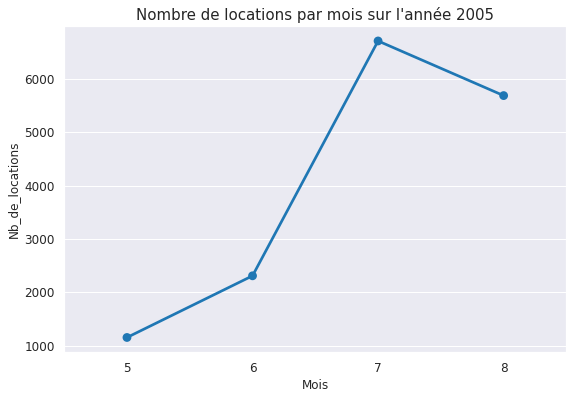

In [103]:
# Indicateur graphique : nombre de location par mois selon l'année.

from matplotlib import pyplot as plt
import seaborn as sns


def rentalPerMonth(engine, annee):

    s = "SELECT MONTH(rental_date) as 'Mois', count(MONTH(rental_date)) as 'Nb_de_locations' \
         FROM rental \
         WHERE YEAR(rental_date) = %s \
         GROUP BY MONTH(rental_date);" %(str(annee))

    data = pd.read_sql_query(s, engine)

    sns.set_style("darkgrid")
    sns.set_context("notebook", rc={"xtick.labelsize":12, "ytick.labelsize":12})

    plt.figure(figsize=(9,6))
    plt.subplot(111)

    sns.pointplot(data=data, x="Mois", y="Nb_de_locations")

    plt.title("Nombre de locations par mois sur l'année %s" %annee, fontsize = 15)

    plt.show()

    plt.close()

    return 

sakila = connect_db(myUser, myPassword, myHost, "sakila")

rentalPerMonth(sakila, 2005)

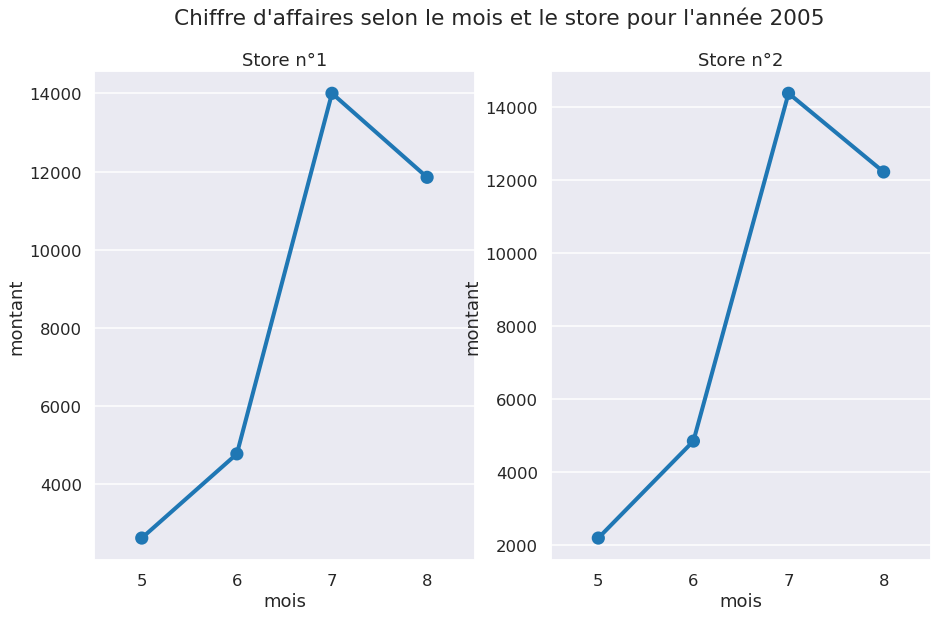

In [108]:
def chiffreDAffaires(engine, annee):

    s1 = "SELECT sto.store_id, YEAR(p.payment_date) as 'annee', MONTH(p.payment_date) as 'mois', p.amount as 'montant' \
          FROM payment as p \
          JOIN staff as sta ON p.staff_id = sta.staff_id \
          JOIN store as sto ON sta.store_id = sto.store_id \
          WHERE YEAR(p.payment_date) = %s AND sto.store_id = 1;" %annee

    data1 = pd.read_sql_query(s1, engine)
    data1_sum = pd.DataFrame(data1.groupby(['mois'])['montant'].sum()).reset_index()
    s2 = "SELECT sto.store_id, YEAR(p.payment_date) as 'annee', MONTH(p.payment_date) as 'mois', p.amount as 'montant' \
          FROM payment as p \
          JOIN staff as sta ON p.staff_id = sta.staff_id \
          JOIN store as sto ON sta.store_id = sto.store_id \
          WHERE YEAR(p.payment_date) = %s AND sto.store_id = 2;" %annee

    data2 = pd.read_sql_query(s2, engine)
    data2_sum = pd.DataFrame(data2.groupby(['mois'])['montant'].sum()).reset_index()

    sns.set_style("darkgrid")
    sns.set_context("talk")

    sns.set_style("darkgrid")

    plt.figure(figsize=(15,9))

    plt.subplot(121)
    sns.pointplot(data=data1_sum,x="mois",y="montant")
    plt.title("Store n°1")

    plt.subplot(122)
    sns.pointplot(data=data2_sum,x="mois",y="montant")
    plt.title("Store n°2")

    plt.suptitle("Chiffre d'affaires selon le mois et le store pour l'année %s" %annee)
    plt.show()
    plt.close()

    return

sakila = connect_db(myUser, myPassword, myHost, "sakila")

chiffreDAffaires(sakila, 2005)